# Elo Merchant Category Recommendation - XGBoost
End date: _2019. february 19._<br/>

This tutorial is the first part of the [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import scipy
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def displayDataInHTMLTable(columns, rows, df):
    html = '<table>'
    html+= '<thead><tr><th>&nbsp;</th>'
    for col_item in columns:
        html+= '<th>' + str(col_item) + '</th>'
    html+= '</tr></thead><tbody>'

    for x in range(0, len(df)):
        html+= '<tr>'
        html+= '<td><b>' + rows[x] + '</b></td>'

        for y in range(0, len(df[0])):
            html+= '<td>' + df[x][y] + '</td>'
    html+= '</tr>'

    html+= '</tbody></table>'
    display(HTML(html))

### Train and test set

In [4]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

201,917 records and 6 features in train set.
123,623 records and 5 features in test set.
Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)


In [5]:
df_train = pd.get_dummies(df_train, columns=['feature_1', 'feature_2'])
df_test = pd.get_dummies(df_test, columns=['feature_1', 'feature_2'])

In [6]:
df_train_p = df_train
'''[
    df_train['target'] > -30
]'''
df_test_p = df_test
'''[
    df_test['first_active_month'] != 'C_ID_c27b4f80f7'
]'''

"[\n    df_test['first_active_month'] != 'C_ID_c27b4f80f7'\n]"

In [7]:
df_train_p[:3]

,first_active_month,card_id,feature_3,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-06,C_ID_92a2005557,1,-0.820312,0,0,0,0,1,0,1,0
1,2017-01,C_ID_3d0044924f,0,0.392822,0,0,0,1,0,1,0,0
2,2016-08,C_ID_d639edf6cd,0,0.687988,0,1,0,0,0,0,1,0


In [8]:
df_test_p[:3]

,first_active_month,card_id,feature_3,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-04,C_ID_0ab67a22ab,1,0,0,1,0,0,0,0,1
1,2017-01,C_ID_130fd0cbdd,0,0,1,0,0,0,0,0,1
2,2017-08,C_ID_b709037bc5,1,0,0,0,0,1,1,0,0


In [9]:
print('Train set reduced to {:,} ({:.5f}% reduction)'.format(df_train_p.shape[0], 100*(1-df_train_p.shape[0]/df_train.shape[0])))
print('Test set reduced to {:,} ({:.5f}% reduction)'.format(df_test_p.shape[0], 100*(1-df_test_p.shape[0]/df_test.shape[0])))

del df_train, df_test
gc.collect()

Train set reduced to 201,917 (0.00000% reduction)
Test set reduced to 123,623 (0.00000% reduction)


49

### Transactions

In [10]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
print("{:,} records and {} features in historical transactions set.".format(df_hist_trans.shape[0], df_hist_trans.shape[1]))

df_hist_trans = reduce_mem_usage(df_hist_trans)

29,112,361 records and 14 features in historical transactions set.
Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)


In [11]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
print("{:,} records and {} features in new transactions set.".format(df_new_trans.shape[0], df_new_trans.shape[1]))

df_new_trans = reduce_mem_usage(df_new_trans)

1,963,031 records and 14 features in new transactions set.
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [12]:
df_hist_trans_p = df_hist_trans[
    (df_hist_trans['state_id'] > 0) &
    (df_hist_trans['city_id'] > 0) &
    (df_hist_trans['category_3'] != np.nan) &
    (df_hist_trans['category_2'] != np.nan) &
    (df_hist_trans['installments'] > -1) &
    (df_hist_trans['installments'] < 999) &
    (df_hist_trans['purchase_amount'] < 0.5) &
    (df_hist_trans['merchant_category_id'] > -1)
]

df_new_trans_p = df_new_trans
'''[
    (df_new_trans['state_id'] > 0) &
    (df_new_trans['city_id'] > 0) &
    (df_new_trans['category_3'] != np.nan) &
    (df_new_trans['category_2'] != np.nan) &
    (df_new_trans['installments'] > -1) &
    (df_new_trans['installments'] < 999) &
    (df_new_trans['purchase_amount'] < 0.5) &
    (df_new_trans['merchant_category_id'] > -1)
]'''

"[\n    (df_new_trans['state_id'] > 0) &\n    (df_new_trans['city_id'] > 0) &\n    (df_new_trans['category_3'] != np.nan) &\n    (df_new_trans['category_2'] != np.nan) &\n    (df_new_trans['installments'] > -1) &\n    (df_new_trans['installments'] < 999) &\n    (df_new_trans['purchase_amount'] < 0.5) &\n    (df_new_trans['merchant_category_id'] > -1)\n]"

In [13]:
df_hist_trans_p['authorized_flag'] = df_hist_trans_p['authorized_flag'].map({'N': 0, 'Y': 1})
df_new_trans_p['authorized_flag'] = df_new_trans_p['authorized_flag'].map({'N': 0, 'Y': 1})

df_hist_trans_p['category_1'] = df_hist_trans_p['category_1'].map({'N': 0, 'Y': 1})
df_new_trans_p['category_1'] = df_new_trans_p['category_1'].map({'N': 0, 'Y': 1})

df_hist_trans_p['category_2'] = pd.to_numeric(df_hist_trans_p['category_2'])
df_new_trans_p['category_2'] = pd.to_numeric(df_new_trans_p['category_2'])

df_hist_trans_p['category_3'] = df_hist_trans_p['category_3'].map({'A': 0, 'B': 1, 'C': 2})
df_new_trans_p['category_3'] = df_new_trans_p['category_3'].map({'A': 0, 'B': 1, 'C': 2})

df_hist_trans_p = pd.get_dummies(df_hist_trans_p, columns=['category_2', 'category_3'])
df_new_trans_p = pd.get_dummies(df_new_trans_p, columns=['category_2', 'category_3'])

In [14]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

In [15]:
df_new_trans_p['purchase_date'] = pd.to_datetime(df_new_trans_p['purchase_date'])
df_new_trans_p = create_date_features(df_new_trans_p, 'purchase_date', 'purchase')

In [16]:
df_hist_trans_p['purchase_date'] = pd.to_datetime(df_hist_trans_p['purchase_date'])
df_hist_trans_p = create_date_features(df_hist_trans_p, 'purchase_date', 'purchase')

In [17]:
df_hist_trans_p[:3]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,category_3_0,category_3_1,category_3_2,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,...,1,0,0,2017,6,25,15,25,6,2
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,...,1,0,0,2017,7,15,12,28,5,3
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,...,1,0,0,2017,8,9,22,32,2,3


In [18]:
df_new_trans_p[:3]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,category_3_0.0,category_3_1.0,category_3_2.0,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,...,0,1,0,2018,3,11,14,10,6,1
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,...,0,1,0,2018,3,19,18,12,0,1
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,...,0,1,0,2018,4,26,14,17,3,2


In [19]:
print('New set reduced to {:,} ({:.5f}% reduction)'.format(df_new_trans_p.shape[0], 100*(1-df_new_trans_p.shape[0]/df_new_trans.shape[0])))
print('Historical set reduced to {:,} ({:.5f}% reduction)'.format(df_hist_trans_p.shape[0], 100*(1-df_hist_trans_p.shape[0]/df_hist_trans.shape[0])))

del df_new_trans, df_hist_trans
gc.collect()

New set reduced to 1,963,031 (0.00000% reduction)
Historical set reduced to 25,884,939 (11.08609% reduction)


224

In [29]:
def aggregate_transactions(trans, prefix):  
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9

    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['sum', 'mean'],
        'category_2_2.0': ['sum', 'mean'],
        'category_2_3.0': ['sum', 'mean'],
        'category_2_4.0': ['sum', 'mean'],
        'category_2_5.0': ['sum', 'mean'],
        'category_3_0': ['sum', 'mean'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'mean', 'max', 'min', 'std'],
        'purchase_year': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_day': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_hour': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_weekofyear': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_dayofweek': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_quarter': ['mean', 'median', 'max', 'min', 'std'],
        'month_lag': ['min', 'max']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [24]:
df_new_trans_p.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount',
       'purchase_date', 'state_id', 'subsector_id', 'category_2_1.0',
       'category_2_2.0', 'category_2_3.0', 'category_2_4.0', 'category_2_5.0',
       'category_3_0.0', 'category_3_1.0', 'category_3_2.0', 'purchase_year',
       'purchase_month', 'purchase_day', 'purchase_hour',
       'purchase_weekofyear', 'purchase_dayofweek', 'purchase_quarter'],
      dtype='object')

In [28]:
df_hist_trans_p.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount',
       'purchase_date', 'state_id', 'subsector_id', 'category_2_1.0',
       'category_2_2.0', 'category_2_3.0', 'category_2_4.0', 'category_2_5.0',
       'category_3_0', 'category_3_1', 'category_3_2', 'purchase_year',
       'purchase_month', 'purchase_day', 'purchase_hour',
       'purchase_weekofyear', 'purchase_dayofweek', 'purchase_quarter'],
      dtype='object')

In [25]:
df_new_trans_p_agg = aggregate_transactions(df_new_trans_p, prefix='new_')

In [26]:
df_new_trans_p_agg[:3]

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_category_1_sum,new_category_1_mean,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_2.0_sum,new_category_2_2.0_mean,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,2,1,0,0.000000,1,0.500000,0,0.0,...,1,0,0.707107,2.000000,2.0,2,2,0.000000,2,2
1,C_ID_0001238066,26,26,1,2,0.076923,20,0.769231,0,0.0,...,6,0,1.799573,1.346154,1.0,2,1,0.485165,1,2
2,C_ID_0001506ef0,2,2,1,0,0.000000,0,0.000000,0,0.0,...,4,3,0.707107,1.000000,1.0,1,1,0.000000,1,1


In [30]:
df_hist_trans_p_agg = aggregate_transactions(df_hist_trans_p, prefix='hist_')

In [31]:
df_hist_trans_p_agg[:3]

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,...,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_dayofweek_std,hist_purchase_quarter_mean,hist_purchase_quarter_median,hist_purchase_quarter_max,hist_purchase_quarter_min,hist_purchase_quarter_std,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,119,89,0.747899,0,0,0.0,0.000000,0.0,0.0,...,6,0,1.839485,2.369748,2.0,4,1,1.103658,-12,0
1,C_ID_0001238066,113,110,0.973451,0,0,94.0,0.831858,0.0,0.0,...,6,0,1.950720,2.814159,4.0,4,1,1.461095,-5,0
2,C_ID_0001506ef0,60,56,0.933333,0,0,2.0,0.033333,0.0,0.0,...,6,0,1.755057,2.500000,2.5,4,1,1.420193,-13,0


### Merchants

In [32]:
df_merch = pd.read_csv("input/merchants.csv")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

df_merch = reduce_mem_usage(df_merch)

334,696 records and 22 features in merchant set.
Starting memory usage: 56.18 MB
Reduced memory usage: 30.32 MB (46.0% reduction)


In [33]:
df_merch_p = df_merch[
    (df_merch['numerical_1'] < 0.1 ) &
    (df_merch['numerical_2'] < 0.1 ) &
    (df_merch['category_2'] != np.nan) &
    (df_merch['avg_sales_lag3'] < 100) &
    (df_merch['avg_sales_lag6'] < 100) &
    (df_merch['avg_sales_lag12'] < 100) &
    (df_merch['avg_purchases_lag6'] < 20) &
    (df_merch['avg_purchases_lag12'] < 20)
]

df_merch_p['category_1'] = df_merch_p['category_1'].map({'N': 0, 'Y': 1})
df_merch_p['category_2'] = pd.to_numeric(df_merch_p['category_2'])
df_merch_p['category_4'] = df_merch_p['category_4'].map({'N': 0, 'Y': 1})
df_merch_p['most_recent_sales_range'] = df_merch_p['most_recent_sales_range'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})
df_merch_p['most_recent_purchases_range'] = df_merch_p['most_recent_purchases_range'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})

df_merch_p = pd.get_dummies(df_merch_p, columns=['category_2', 'most_recent_sales_range', 'most_recent_purchases_range'])

In [34]:
df_merch_p[:3]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,...,most_recent_sales_range_0,most_recent_sales_range_1,most_recent_sales_range_2,most_recent_sales_range_3,most_recent_sales_range_4,most_recent_purchases_range_0,most_recent_purchases_range_1,most_recent_purchases_range_2,most_recent_purchases_range_3,most_recent_purchases_range_4
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,0,-0.40,9.666667,3,...,0,0,0,0,1,0,0,0,0,1
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,0,-0.72,1.750000,3,...,0,0,0,0,1,0,0,0,0,1
25,M_ID_2be211b847,35,456,21,-0.057465,-0.057465,0,1.00,1.000000,1,...,0,0,0,0,1,0,0,0,0,1


In [35]:
print('New set reduced to {:,} ({:.5f}% reduction)'.format(df_merch_p.shape[0], 100*(1-df_merch_p.shape[0]/df_merch.shape[0])))

del df_merch
gc.collect()

New set reduced to 315,165 (5.83544% reduction)


106

### Merging

In [36]:
df_train_p = pd.merge(df_train_p, df_new_trans_p_agg, on='card_id', how='left')
df_test_p = pd.merge(df_test_p, df_new_trans_p_agg, on='card_id', how='left')
del df_new_trans_p_agg
gc.collect()

0

In [37]:
df_train_p = pd.merge(df_train_p, df_hist_trans_p_agg, on='card_id', how='left')
df_test_p = pd.merge(df_test_p, df_hist_trans_p_agg, on='card_id', how='left')
del df_hist_trans_p_agg
gc.collect()

14

In [38]:
df_train_p[:3]

,first_active_month,card_id,feature_3,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,...,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_dayofweek_std,hist_purchase_quarter_mean,hist_purchase_quarter_median,hist_purchase_quarter_max,hist_purchase_quarter_min,hist_purchase_quarter_std,hist_month_lag_min,hist_month_lag_max
0,2017-06,C_ID_92a2005557,1,-0.820312,0,0,0,0,1,0,...,6.0,0.0,1.980420,3.030888,3.0,4.0,1.0,1.037575,-8.0,0.0
1,2017-01,C_ID_3d0044924f,0,0.392822,0,0,0,1,0,1,...,6.0,0.0,1.973319,2.512739,3.0,4.0,1.0,1.150703,-12.0,0.0
2,2016-08,C_ID_d639edf6cd,0,0.687988,0,1,0,0,0,0,...,6.0,0.0,1.581664,1.976744,2.0,4.0,1.0,1.123099,-13.0,0.0


In [39]:
df_test_p[:3]

,first_active_month,card_id,feature_3,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,...,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_dayofweek_std,hist_purchase_quarter_mean,hist_purchase_quarter_median,hist_purchase_quarter_max,hist_purchase_quarter_min,hist_purchase_quarter_std,hist_month_lag_min,hist_month_lag_max
0,2017-04,C_ID_0ab67a22ab,1,0,0,1,0,0,0,0,...,6.0,0.0,1.595448,3.155556,3.0,4.0,2.0,0.796457,-8.0,0.0
1,2017-01,C_ID_130fd0cbdd,0,0,1,0,0,0,0,0,...,6.0,0.0,1.704071,1.500000,1.5,2.0,1.0,0.503322,-13.0,0.0
2,2017-08,C_ID_b709037bc5,1,0,0,0,0,1,1,0,...,4.0,1.0,1.253566,3.428571,4.0,4.0,1.0,1.133893,-6.0,0.0


## LigthGBM
For more details click [here](https://lightgbm.readthedocs.io/en/latest/).

In [40]:
target = df_train_p['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train_p.columns if c not in drops]
features = list(df_train_p[use_cols].columns)
df_train_p[features][:3]

,feature_3,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,new_transactions_count,...,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_dayofweek_std,hist_purchase_quarter_mean,hist_purchase_quarter_median,hist_purchase_quarter_max,hist_purchase_quarter_min,hist_purchase_quarter_std,hist_month_lag_min,hist_month_lag_max
0,1,0,0,0,0,1,0,1,0,23.0,...,6.0,0.0,1.980420,3.030888,3.0,4.0,1.0,1.037575,-8.0,0.0
1,0,0,0,0,1,0,1,0,0,6.0,...,6.0,0.0,1.973319,2.512739,3.0,4.0,1.0,1.150703,-12.0,0.0
2,0,0,1,0,0,0,0,1,0,1.0,...,6.0,0.0,1.581664,1.976744,2.0,4.0,1.0,1.123099,-13.0,0.0


In [41]:
param = {
    'num_leaves': 50,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train_p))
predictions = np.zeros(len(df_test_p))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_p.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train_p.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train_p.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train_p.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test_p[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.74214	valid_1's rmse: 3.81151
[200]	training's rmse: 3.67751	valid_1's rmse: 3.77689
[300]	training's rmse: 3.6307	valid_1's rmse: 3.75912
[400]	training's rmse: 3.59449	valid_1's rmse: 3.7484
[500]	training's rmse: 3.56275	valid_1's rmse: 3.7413
[600]	training's rmse: 3.53549	valid_1's rmse: 3.73608
[700]	training's rmse: 3.51176	valid_1's rmse: 3.73192
[800]	training's rmse: 3.49038	valid_1's rmse: 3.7295
[900]	training's rmse: 3.47008	valid_1's rmse: 3.72761
[1000]	training's rmse: 3.45184	valid_1's rmse: 3.72639
[1100]	training's rmse: 3.43409	valid_1's rmse: 3.72565
[1200]	training's rmse: 3.41801	valid_1's rmse: 3.72501
[1300]	training's rmse: 3.40261	valid_1's rmse: 3.72434
[1400]	training's rmse: 3.38824	valid_1's rmse: 3.72396
[1500]	training's rmse: 3.37453	valid_1's rmse: 3.72387
[1600]	training's rmse: 3.36142	valid_1's rmse: 3.72378
[1700]	training's rmse: 3.34884	valid_1's rms

In [42]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.702561432853876


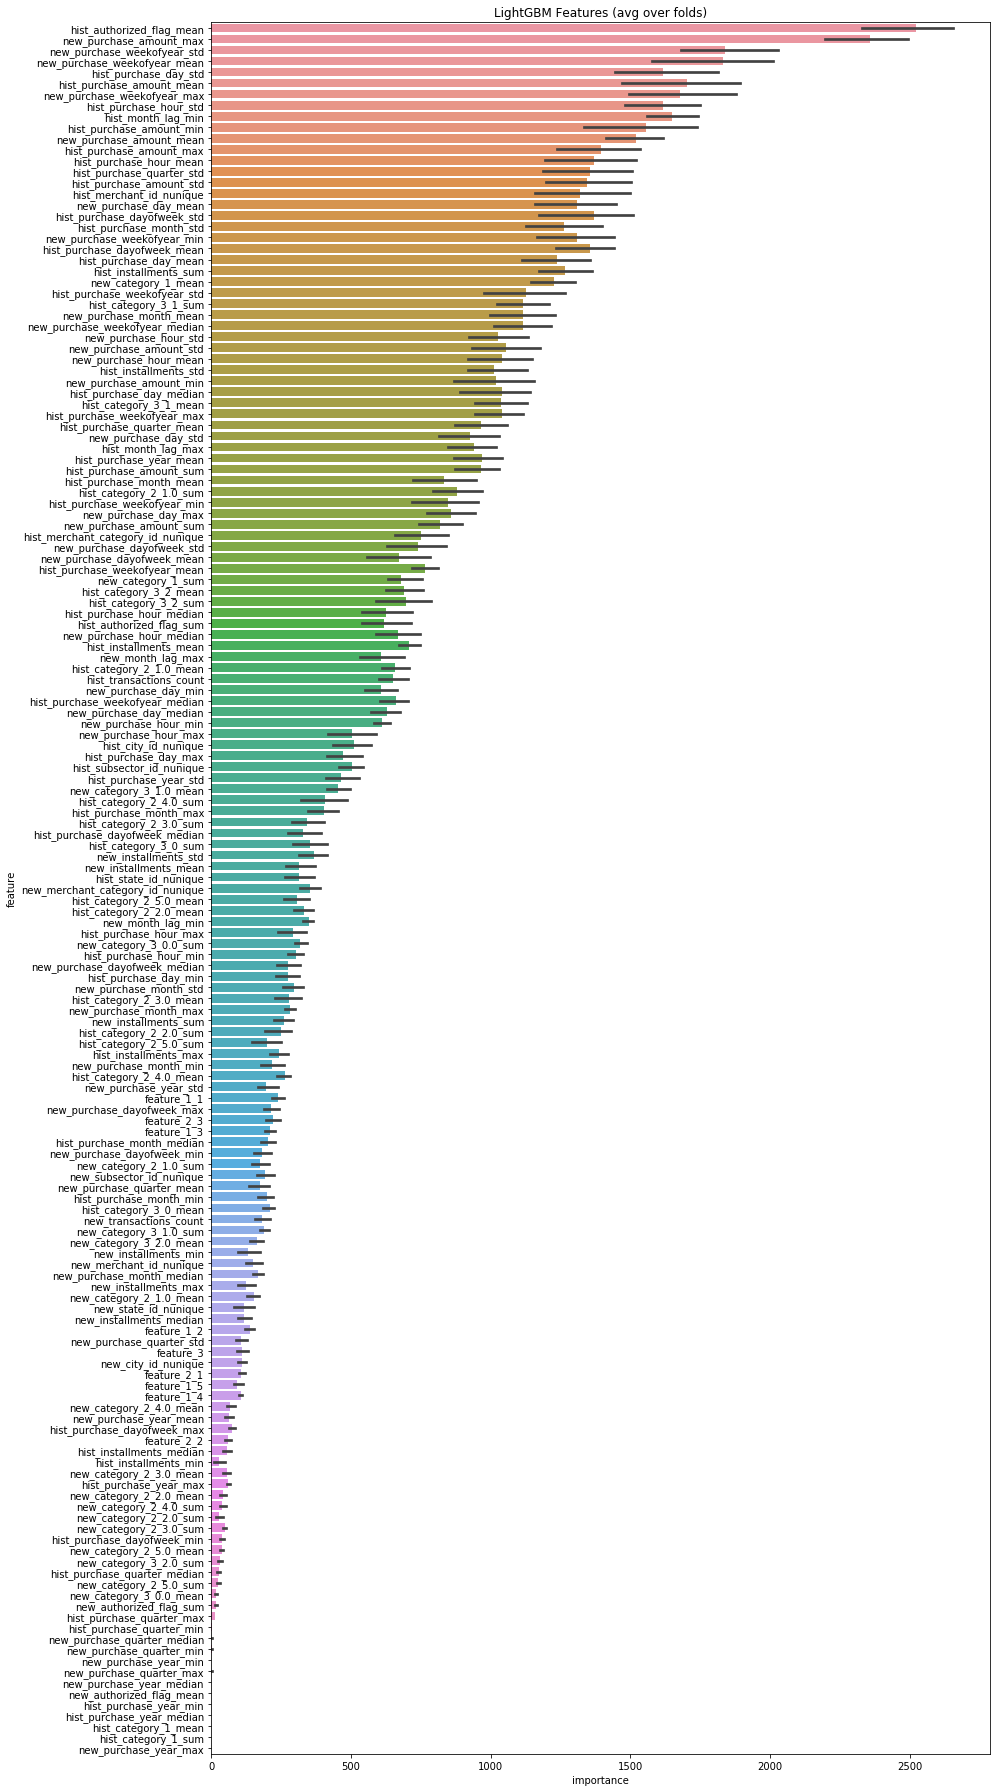

In [43]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [44]:
sorted(list(zip(clf.feature_importance(), features)), reverse=True)

[(2166, 'hist_authorized_flag_mean'),
 (2064, 'new_purchase_amount_max'),
 (1565, 'new_purchase_weekofyear_std'),
 (1486, 'hist_month_lag_min'),
 (1422, 'hist_purchase_hour_std'),
 (1404, 'new_purchase_weekofyear_mean'),
 (1393, 'new_purchase_weekofyear_max'),
 (1350, 'hist_purchase_day_std'),
 (1320, 'hist_purchase_amount_mean'),
 (1317, 'new_purchase_amount_mean'),
 (1207, 'hist_purchase_amount_min'),
 (1116, 'new_category_1_mean'),
 (1108, 'hist_purchase_dayofweek_mean'),
 (1101, 'new_purchase_weekofyear_min'),
 (1101, 'hist_purchase_amount_max'),
 (1099, 'hist_installments_sum'),
 (1094, 'hist_purchase_amount_std'),
 (1081, 'hist_purchase_hour_mean'),
 (1062, 'hist_purchase_quarter_std'),
 (1040, 'hist_merchant_id_nunique'),
 (1028, 'new_purchase_day_mean'),
 (1017, 'hist_purchase_dayofweek_std'),
 (1013, 'hist_purchase_day_mean'),
 (1012, 'hist_purchase_month_std'),
 (967, 'hist_category_3_1_sum'),
 (945, 'new_purchase_weekofyear_median'),
 (930, 'new_purchase_month_mean'),
 (886,

In [45]:
df_sub = pd.DataFrame({"card_id":df_test_p["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)

### XGBoost
For more details click [here](https://xgboost.readthedocs.io/en/latest/).

In [ ]:
xgb_params = {
    'eta': 0.005,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8, 
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True
}

#folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))

feature_importance_xgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=df_train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(df_train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    fold_importance_xgb = pd.DataFrame()
    fold_importance_xgb["feature"] = features
    #fold_importance_df["importance"] = xgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_xgb, fold_importance_xgb], axis=0)
    predictions_xgb += xgb_model.predict(xgb.DMatrix(df_test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits

In [ ]:
cross_validation_xgb = np.sqrt(mean_squared_error(target, oof_xgb))
print('Cross-validation score: ' + str(cross_validation_xgb))

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.savefig('xgboost_importances.png')

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions_xgb
df_sub.to_csv("output/xgboost_{}.csv".format(cross_validation_xgb), index=False)

LB score: 33.041

In [56]:
df_sub = pd.DataFrame({"card_id": df_test["card_id"].values, "target": -33.218750})
#df_sub["target"] = predictions_xgb
df_sub.to_csv("output/outliers.csv", index=False)

LB score:

In [57]:
df_sub = pd.DataFrame({"card_id": df_test["card_id"].values, "target": 0})
#df_sub["target"] = predictions_xgb
df_sub.to_csv("output/zeros.csv", index=False)